# 📓 Baseline Model 2: HWES with Decomposition Insights


In this notebook, we forecast the **fastest Bitcoin transaction fee (sats/vByte)** for the next 24 hours using **Holt-Winters Exponential Smoothing (HWES)**.

---

### 🧠 Why HWES? Additive or Multiplicative?

We analyzed the seasonality and trend of the time series using both **additive** and **multiplicative** decompositions. Here's what we found:

**✅ Additive Decomposition**

- Seasonal pattern has **constant amplitude** regardless of trend level.
- Works well when seasonality is **independent of the trend level**.
- Residuals look okay but large spikes (likely outliers) are present.

✅ **Multiplicative Decomposition**

- Seasonal component **scales with the level of the series** (i.e., as fees rise, seasonal amplitude increases).
- This fits **real-world Bitcoin fee behavior more accurately**:
    - High congestion periods (e.g., spikes in March) show **amplified seasonal patterns**.
    - Multiplicative seasonality captures this well.
- Residuals are tighter and better-behaved around 0 compared to additive, except for extreme spikes, which are expected.

⚠️ **Note:** Multiplicative models require **strictly positive values**.


### 🔢 Step 1: Import Required Libraries

In [26]:

import pandas as pd
import numpy as np
from itertools import product
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_arch
import matplotlib.pyplot as plt
import seaborn as sns
from utils import mape, hwes_cross_val, hwes_train_test


### 📥 Step 2: Load and Prepare the Data

We load the dataset and apply a small positive shift to avoid issues with multiplicative modeling (HWES cannot handle zero or negative values).

In [27]:

df = pd.read_parquet('../data/processed/preprocessed_hwes.parquet')

# Count how many values are exactly zero
zero_count = (df['recommended_fee_fastestFee'] == 0).sum()
print(f"Number of zero values in 'recommended_fee_fastestFee': {zero_count}")

# # Add small constant to avoid zeros for multiplicative modeling
# epsilon = 0.01
# df['recommended_fee_fastestFee'] += epsilon

# Full series for final model
series_full = df['recommended_fee_fastestFee'].astype(float).sort_index()
series_full.index.freq = pd.infer_freq(series_full.index)

Number of zero values in 'recommended_fee_fastestFee': 0


In [28]:
series_full.head()

timestamp
2025-03-05 02:10:00    2.0
2025-03-05 02:15:00    2.0
2025-03-05 02:20:00    3.0
2025-03-05 02:25:00    4.0
2025-03-05 02:30:00    2.0
Freq: 5min, Name: recommended_fee_fastestFee, dtype: float64

### ✂️ Step 3: Train-Test Split

We hold out the last 24 hours of the sample as a test set for evaluating different HWES parameter combinations. 

In [29]:

forecast_horizon = 288  # 24 hours * (60 / 5)
train_full = series_full[:-forecast_horizon]
test = series_full[-forecast_horizon:]


### 🔁 Step 4: Extracted Sampled Data and Apply `MinMaxScaler()`

In addition, the last 7-day sample is used for tuning the model parameters. `MinMaxScaler` is used to prevent numerical instability during grid search while the shift ensures values to be strictly positive. After identifying the best model structure, the model is trained on full, real-scale data. 

In [30]:
# Subset for hyperparameter tuning (last 7 days)
train_sampled = train_full.last('7D')
train_sampled.index.freq = pd.infer_freq(train_sampled.index)

# end_time = train_full.index[-1]
# start_time = end_time - pd.Timedelta(days=7)
# series_sampled = train_full.loc[start_time:end_time]

/var/folders/ct/kvv_m0bd68s01xk476lgc7sw0000gn/T/ipykernel_65356/525058880.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  train_sampled = train_full.last('7D')


In [31]:
scaler = MinMaxScaler(feature_range=(1, 2))  # Always > 0
train_sampled_scaled = pd.Series(
    scaler.fit_transform(train_sampled.values.reshape(-1, 1)).flatten(),
    index=train_sampled.index
)

In [7]:
# # Create and fit the scaler
# scaler = RobustScaler()
# scaled = pd.Series(
#     scaler.fit_transform(train_sampled.values.reshape(-1, 1)).flatten(),
#     index=train_sampled.index
# )

In [8]:
# # Shift scaled data to be strictly positive
# min_val = scaled.min()
# shift = abs(min_val) + 1e-3 if min_val <= 0 else 0
# scaled_shifted = scaled + shift

# train_sampled_scaled_shifted = pd.Series(scaled_shifted, index=train_sampled.index)

### ⚙️ Step 5: Efficient Hyperparameter Optimization (Additive & Multiplicative)

We test a mix of additive and multiplicative models, prioritizing those that better represent real-world fee dynamics (scaling seasonal effects).

We try both options of 1) single train-validation split (last 7-days only) and 2) rolling window cross-validation. The latter is more robust but computationally expensive. 

In [33]:
# param_grid = [
#     ('add', 'add', False),
#     ('add', 'add', True),
#     ('mul', 'mul', False),
#     ('mul', 'mul', True),
#     ('add', 'mul', False),
#     ('mul', 'add', False),
#     (None, None, False),
# ]

# Define all grid combinations
trend_options = ['add', 'mul', None]
seasonal_options = ['add', 'mul', None]
damped_options = [True, False]

param_grid = [
    (trend, seasonal, damped)
    for trend, seasonal, damped in product(trend_options, seasonal_options, damped_options)
    if not (trend is None and damped)
]

best_mae= float('inf')
best_params = None
results = []

for trend, seasonal, damped in param_grid:
    try:
        model = ExponentialSmoothing(
            train_sampled_scaled,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=288 if seasonal else None,
            damped_trend=damped
        )
        fit = model.fit(optimized=True, use_brute=True)
        pred = fit.forecast(forecast_horizon)

        mae = mean_absolute_error(test, pred)
        mape = mean_absolute_percentage_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        results.append((trend, seasonal, damped, mae, mape, rmse))

        if mae < best_mae:
            best_mae = mae
            best_params = (trend, seasonal, damped)

    except Exception as e:
        print(f"Error with parameters {trend}, {seasonal}, {damped}: {e}")ç

/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: divide by zero encountered in matmul
  return err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: invalid value encountered in matmul
  return err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/

In [10]:
# cv_results = hwes_cross_val(
#     series=train_full,
#     seasonal_periods=288,
#     horizon=288,
#     window_size=2016,  # 7 days
#     step=288,
#     scaler=scaler
# )

# cv_results

### ✅ Step 6: Report Best HWES Parameters

Based on the above hyperparmeter tuning, both options yield similar best parameters.

In [11]:

best_trend, best_seasonal, best_damped = best_params
print(f"Best HWES parameters: trend={best_trend}, seasonal={best_seasonal}, damped={best_damped}")


Best HWES parameters: trend=mul, seasonal=mul, damped=True


### 🏁 Step 7: Train Final Model on Full Dataset

With the best parameter set identified, we retrain the model on the full dataset to produce a final forecast.

In [12]:

final_model = ExponentialSmoothing(
    train_full,
    trend=best_trend,
    seasonal=best_seasonal,
    seasonal_periods=288 if best_seasonal else None,
    damped_trend=best_damped
)
final_fit = final_model.fit(optimized=True, use_brute=True)
forecast = final_fit.forecast(288)


/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: divide by zero encountered in matmul
  return err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: invalid value encountered in matmul
  return err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmo

### 🧪 Step 8: Residual Analysis
We analyze the residuals of the final model to ensure they are normally distributed and uncorrelated. This is crucial for validating the model's performance.

In [13]:
fitted_values = final_fit.fittedvalues
residuals = train_full - fitted_values

In [14]:
# Check for Autocorrelation (Ljung-Box Test)
# p-value < 0.05 indicates significant autocorrelation
lb_test = acorr_ljungbox(residuals.dropna(), lags=[288], return_df=True)
lb_test


,lb_stat,lb_pvalue
288,619.759115,2.199206e-26


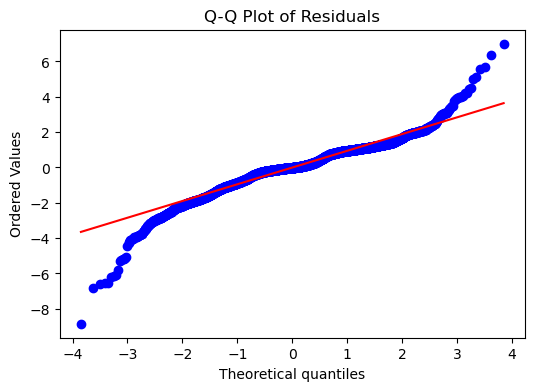

In [15]:
# Check for Normality (Q-Q Plot)
plt.figure(figsize=(6, 4))
stats.probplot(residuals.dropna(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()


In [16]:
# Check for Heteroskedasticity
# p-value < 0.05 indicates heteroskedasticity
arch_test = het_arch(residuals.dropna())
print(f"ARCH test p-value: {arch_test[1]}")

ARCH test p-value: 5.385602520475164e-179


### 📊 Step 9: Evaluate Forecast Accuracy

We evaluate the forecast using MAE, MAPE, and RMSE on the last 24 hours of actual data from the full dataset.

In [17]:

mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"Final Forecast MAE: {mae:.4f}")
print(f"Final Forecast MAPE: {mape:.4f}")
print(f"Final Forecast RMSE: {rmse:.4f}")


Final Forecast MAE: 1.2119
Final Forecast MAPE: 0.6978
Final Forecast RMSE: 1.4760


### 📈 Step 9: Visualize Forecast vs Actual

We plot the historical series (last 7 days), the actual values from the last 24 hours, and the forecast to visually assess model performance.

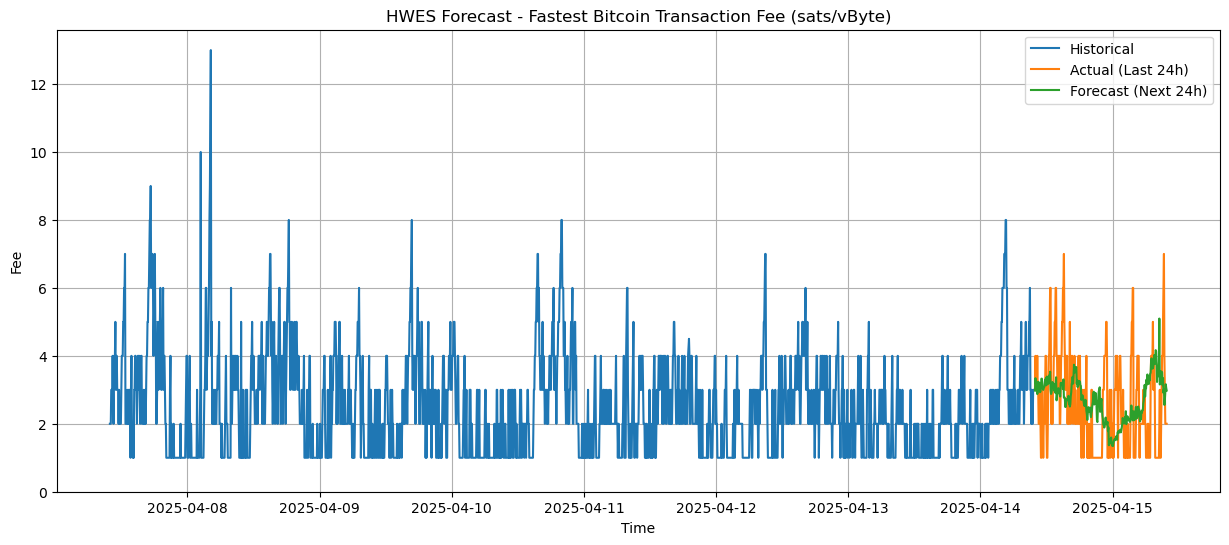

In [18]:

plt.figure(figsize=(15, 6))
plt.plot(train_sampled, label="Historical")
plt.plot(test.index, test, label="Actual (Last 24h)")
plt.plot(test.index, forecast, label="Forecast (Next 24h)")
plt.title("HWES Forecast - Fastest Bitcoin Transaction Fee (sats/vByte)")
plt.xlabel("Time")
plt.ylabel("Fee")
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.show()


### 🔍 Step 10: Further Exploration into Spikes

Given the spike of fees to 41 sats / vByte on March 25, we explore how long it took to go from the last median to the maximum fee to better explore potential resampling of the data with different timeframes.

In [19]:
# Find the max value and its timestamp
max_val = series_full.max()
max_time = series_full.idxmax()

# # Compute rolling median (288 = 1-day window for 5min data)
# rolling_median = series_full.rolling(window=288, min_periods=1).median()
# # Get the last median before the peak
# last_median_before_spike = rolling_median[rolling_median.index < max_time].iloc[-1]

# Find when the series first crossed above that median before reaching the max
pre_spike = series_full[series_full.index < max_time]

# Compute global median before the peak
global_median = pre_spike.median()
last_cross_time = pre_spike[pre_spike >= global_median].index[-1]

# Calculate time to peak
time_to_peak = max_time - last_cross_time

# print("Last median before peak:", last_median_before_spike)
print("Overall median before peak:", global_median)
print("Max fee value:", max_val, "at", max_time)
print("Last crossed median at:", last_cross_time)
print("Time to reach peak:", time_to_peak)

Overall median before peak: 3.0
Max fee value: 41.0 at 2025-03-25 21:40:00
Last crossed median at: 2025-03-25 21:35:00
Time to reach peak: 0 days 00:05:00


### ➿ Step 11: Exploration of Various Train and Test Horizon

In addition to utilizing the last 24 hours of data, we explore the impact of different train and test horizons on the model's performance. This helps us understand how the model behaves with varying amounts of historical data and forecast lengths.

In [20]:
# Define parameter ranges
window_sizes = [2016, 2880, 4032]   # e.g., 7 days, 10 days, 14 days (for 5-min data)
horizons = [288, 576]  # e.g., 24h, 48h
methods = ['sliding', 'expanding']
results_all = []

for w in window_sizes:
    for h in horizons:
        for m in methods:
            if m == 'expanding':
                # For expanding, we need to ensure the window size is not larger than the series length
                if w > len(train_full):
                    print(f"Skipping expanding method with window size {w} (too large for series length).")
                    continue

            # Perform cross-validation
            print(f"Running with window={w}, horizon={h}, method={m}...")
            df_result = hwes_train_test(
                series=series_full,
                seasonal_periods=288 if best_seasonal else None,
                horizon=h,
                window_size=w,
                method=m,
                trend=best_trend,
                seasonal=best_seasonal,
                damped_trend=best_damped,
            )
            df_result["window_size"] = w
            df_result["horizon"] = h
            df_result["method"] = m
            results_all.append(df_result)
            

Running with window=2016, horizon=288, method=sliding...


/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: invalid value encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinte

Running with window=2016, horizon=288, method=expanding...


/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: invalid value encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinte

Running with window=2016, horizon=576, method=sliding...


/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: invalid value encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinte

Running with window=2016, horizon=576, method=expanding...


/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: invalid value encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinte

Running with window=2880, horizon=288, method=sliding...


/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: invalid value encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinte

Running with window=2880, horizon=288, method=expanding...


/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: invalid value encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinte

Running with window=2880, horizon=576, method=sliding...


/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: invalid value encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinte

Running with window=2880, horizon=576, method=expanding...


/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: invalid value encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinte

Running with window=4032, horizon=288, method=sliding...


/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: invalid value encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinte

Running with window=4032, horizon=288, method=expanding...


/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: invalid value encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinte

Running with window=4032, horizon=576, method=sliding...


/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: invalid value encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinte

Running with window=4032, horizon=576, method=expanding...


/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: invalid value encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/statsmodels/tsa/holtwinte

In [21]:
all_results_df = pd.concat(results_all, ignore_index=True)
all_results_df

,train_end,mae,rmse,mape,window_size,horizon,method
0,2025-03-12 02:05:00,1.011238,1.287931,0.371456,2016,288,sliding
1,2025-03-13 02:05:00,1.730941,2.112758,0.621327,2016,288,sliding
2,2025-03-14 02:05:00,2.385505,2.799187,0.824984,2016,288,sliding
3,2025-03-15 02:05:00,1.273010,1.801027,0.281265,2016,288,sliding
4,2025-03-16 02:05:00,5.135003,6.240537,2.098083,2016,288,sliding
...,...,...,...,...,...,...,...
153,2025-04-08 02:05:00,1.503404,2.008875,0.597059,4032,576,sliding
154,2025-04-10 02:05:00,1.086217,1.423729,0.589994,4032,576,sliding
155,2025-04-12 02:05:00,1.172715,1.567508,0.441938,4032,576,sliding
156,2025-03-19 02:05:00,1.422747,1.938653,0.355472,4032,576,expanding


In [22]:
# Check for NaN values in the results
all_results_df[all_results_df.isna().any(axis=1)]

,train_end,mae,rmse,mape,window_size,horizon,method


In [23]:
# Summarize error metrics by config
train_test_summary = (
    all_results_df.groupby(["method", "window_size", "horizon"])
    .agg({"mae": "mean", "rmse": "mean", "mape": "mean"})
    .reset_index()
)
train_test_summary

,method,window_size,horizon,mae,rmse,mape
0,expanding,2016,288,1.283011,1.802296,0.429282
1,expanding,2016,576,1.320177,1.816814,0.450211
2,expanding,2880,288,2.583470,4.181232,0.741466
3,expanding,2880,576,2.251876,3.903401,0.746622
4,expanding,4032,288,1.216097,1.670951,0.382414
5,expanding,4032,576,1.339097,1.808039,0.402335
6,sliding,2016,288,2.186858,2.932543,0.875391
7,sliding,2016,576,2.084236,2.954130,0.870953
8,sliding,2880,288,2.022054,2.719599,0.799884
9,sliding,2880,576,2.152533,2.847723,0.870886


In [24]:
# Best configuration (lowest RMSE)
best_config = train_test_summary.loc[train_test_summary["mae"].idxmin()]
print("Best configuration:\n", best_config)

Best configuration:
 method         expanding
window_size         4032
horizon              288
mae             1.216097
rmse            1.670951
mape            0.382414
Name: 4, dtype: object


In [25]:
# RMSE plot across window/horizon
plt.figure(figsize=(10, 6))
sns.lineplot(data=summary, x="window_size", y="mae", hue="horizon", style="method", marker="o")
plt.title("HWES RMSE Across Horizons and Window Sizes")
plt.xlabel("Window Sizes (steps)")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'summary' is not defined

<Figure size 1000x600 with 0 Axes>

### 📌 Step 12: Resample to Different Intervals

Test the model with different resampling intervals (e.g., 5 min, 10 min, 15 min) to see how it performs with different time granularities. This can help identify the best interval for capturing fee dynamics.

In [ ]:
# Each entry is: {"new frequency": factor relative to 5min}
resample_rules = {
    "5min": 1,      # original data
    "15min": 3,     # 3 * 5min = 15min
    "30min": 6,
    "1H": 12,       # 12 * 5min = 60min
    "2H": 24        # 24 * 5min = 120min
}

# Base seasonal periods in 5-min steps
base_seasonal_period = 288  # daily seasonality (24h)

In [ ]:
# Extract best configuration from summary
base_window = int(best_config['window_size'])
base_horizon = int(best_config['horizon'])
best_method = best_config['method']

In [ ]:
subsample_results_list = []

for label, step in resample_rules.items():
    print(f"\n🔁 Running for interval: {label}")

    # Subsample instead of aggregate
    subsample_series = series_full.iloc[::step].copy()

    # Adjust parameters
    window_size = int(base_window / step)
    horizon = int(base_horizon / step)
    seasonal_period = int(base_seasonal_period / step)

    try:
        df_result = hwes_train_test(
            series=subsample_series,
            seasonal_periods=seasonal_period,
            horizon=horizon,
            window_size=window_size,
            method=best_method,         
            trend=best_trend,
            seasonal=best_seasonal,
            damped_trend=best_damped,
        )
        df_result["subsample"] = label
        subsample_results_list.append(df_result)
    except Exception as e:
        print(f"❌ Failed on {label}: {e}")
        continue

In [ ]:
# Combine all results
all_results_subsample_df = pd.concat(subsample_results_list, ignore_index=True)
all_results_subsample_df

In [ ]:
# Check for NaN values in the results
all_results_subsample_df[all_results_subsample_df.isna().any(axis=1)]

In [ ]:
# Summarize error metrics by config
interval_summary = (
    all_results_subsample_df.groupby(["subsample"])
    .agg({"mae": "mean", "rmse": "mean", "mape": "mean"})
    .reset_index()
)
interval_summary

In [ ]:
# Best configuration (lowest RMSE)
best_interval = interval_summary.loc[interval_summary["mae"].idxmin()]
print("Best configuration:\n", best_interval)

In [ ]:
# Sort the DataFrame by MAE
interval_summary_sorted = interval_summary.sort_values("mae").reset_index(drop=True)

# Setup
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = interval_summary_sorted["subsample"]
x_pos = range(len(x))

# Plot bars
mae_bars = plt.bar(x_pos, interval_summary_sorted["mae"], width=bar_width, label="MAE")
rmse_bars = plt.bar([p + bar_width for p in x_pos], interval_summary_sorted["rmse"], width=bar_width, label="RMSE")

# Annotate values on bars
for bar in mae_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.03, f"{height:.2f}", ha='center', va='bottom', fontsize=9)

for bar in rmse_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.03, f"{height:.2f}", ha='center', va='bottom', fontsize=9)

# Labels and formatting
plt.xticks([p + bar_width / 2 for p in x_pos], x)
plt.title("MAE and RMSE by Subsample Interval")
plt.xlabel("Subsample Interval")
plt.ylabel("Error")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

### 🌐 Step 13: Resample to Different Intervals

The below section combines the best configuration from the previous step with the resampling intervals. It will run the HWES model on each subsampled series and evaluate the performance. Be cautious of memory usage and time execution, as this can be computationally intensive depending on the size of data and the number of intervals chosen.

In [ ]:
# base_window_sizes = [2016, 2880, 4032]   # e.g., 7 days, 10 days, 14 days (for 5-min data)
# base_horizons = [288, 576]  # e.g., 24h, 48h

# # Store all results
# all_resample_results = []

# # Run for each resampling interval
# for rule, factor in resample_rules.items():
#     print(f"\n=== Resampling to {rule} interval ===")
#     step = resample_rules[rule]
#     series_resampled = series_full.iloc[::step].copy()

#     window_sizes = [int(w / factor) for w in base_window_sizes]
#     horizons = [int(h / factor) for h in base_horizons]
#     seasonal_periods = int(288 / factor)

#     for w in window_sizes:
#         for h in horizons:
#             for m in methods:
#                 if m == 'expanding' and w > len(series_resampled):
#                     print(f"Skipping expanding method with window size {w} (too large for series length).")
#                     continue

#                 print(f"Running {rule} | window={w}, horizon={h}, method={m}...")
#                 try:
#                     df_result = hwes_train_test(
#                         series=series_resampled,
#                         seasonal_periods=seasonal_periods if best_seasonal else None,
#                         horizon=h,
#                         window_size=w,
#                         method=m,
#                         trend=best_trend,
#                         seasonal=best_seasonal,
#                         damped_trend=best_damped,
#                     )
#                     df_result["window_size"] = w
#                     df_result["horizon"] = h
#                     df_result["method"] = m
#                     df_result["resample"] = rule
#                     all_resample_results.append(df_result)
#                 except Exception as e:
#                     print(f"Failed at {rule} | window={w}, horizon={h}, method={m}: {e}")
#                     continue